In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [4]:
# df_100 = pd.read_csv('dataset/train_test_100_class_261.csv')
# df_500 = pd.read_csv('dataset/train_test_500_class_48.csv')
df_1000 = pd.read_csv('dataset/train_test_1000_class_20.csv')

In [ ]:
STOPWORDS = set(stopwords.words('english'))
RAND_STATE = 13
VOCAB_SIZE = 100000  # vocabulary size
SEQ_LENGTH = 2500  # maximum number of words in an email
EMBEDDING_DIM = 256  # dimention of embeddings

In [6]:
# threshold: number of classes
classes = {
    100: 261,
    500: 48,
    1000: 20,
}

In [7]:
len(STOPWORDS)

179

In [8]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [24]:
# df_100['email_body'] = df_100['email_body'].apply(remove_stopwords)

In [9]:
# df_500['email_body'] = df_500['email_body'].apply(remove_stopwords)
df_1000['email_body'] = df_1000['email_body'].apply(remove_stopwords)

In [10]:
df_1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40203 entries, 0 to 40202
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        40203 non-null  object
 1   date        40203 non-null  object
 2   subject     38246 non-null  object
 3   from        40203 non-null  object
 4   to          40203 non-null  object
 5   email_body  40203 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [13]:
df_1000.describe()

,file,date,subject,from,to,email_body
count,40203,40203,38246,40203,40203,40203
unique,40203,38380,26670,20,9927,39743
top,kaminski___v___sent_mail_1533,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",RE:,jeff.dasovich@enron.com,suzanne.adams@enron.com,
freq,1,136,1213,4339,508,72


In [14]:
# tokenize
def tokenizing(df):
    tokenizer = Tokenizer(
        num_words=VOCAB_SIZE, 
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
        lower=True
    )
    
    tokenizer.fit_on_texts(df['email_body'].values)
    tokens = tokenizer.word_index

    # truncate and pad input sequences
    X = tokenizer.texts_to_sequences(df['email_body'].values)
    X = pad_sequences(X, maxlen=SEQ_LENGTH)

    return (tokenizer, tokens, X)

In [15]:
tokenizer, tokens, X = tokenizing(df_1000)
len(tokens)

44335

In [16]:
type(tokens)

dict

In [17]:
X.shape

(40203, 250)

In [18]:
y = pd.get_dummies(df_1000['from']).values
y.shape

(40203, 20)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RAND_STATE)

In [20]:
x_train.shape

(36182, 250)

In [36]:
# build model
rnn_model = Sequential()
rnn_model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=X.shape[1]))
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(classes[1000], activation='softmax'))

In [37]:
# compile model
rnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [38]:
EPOCHS = 5
BATCH_SIZE = 64

In [ ]:
# train model
history = rnn_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

In [29]:
# test model
accuracy = rnn_model.evaluate(x_test, y_test)
accuracy

126/126 [==============================] - 48s 373ms/step - loss: 0.9391 - accuracy: 0.7466


[0.9390523433685303, 0.7465804815292358]

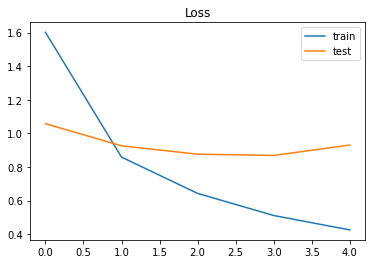

In [30]:
# plot loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

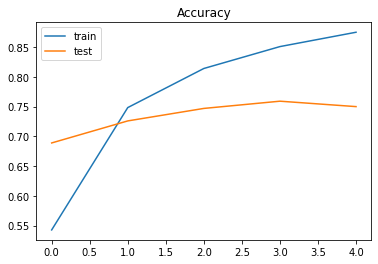

In [34]:
# plot accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# test with an email from the corpus
em = '''pennfutures ecubed is a commentary biweekly email publication concerning the current themes and trends in the energy market if you have trouble rea ding this email please see the document on our website wwwpennfutureorg under pressroom publications august vol no a cool heat wave from august to august record peak electricity demand driven by a swel tering heat wave severely tested the reliability of the competitive pjm mar ket the pjm market passed its stress test with little public notice or cre dit as usual only ships that sink or planes that crash draw headlines with airconditioners battling near degree temperatures consumers set three new peak usage records on august and with demand hitting megawatts mw and mw respectively these new recor ds smashed the old peak of approximately mw set in a and contr ibuted to unhealthy air in large parts of the midatlantic region they als o highlight the need to enact better demand response programs and energy ef ficiency policies in order to reduce the strain placed on power supplies as well as to protect the environment and public health the ability of the pjm competitive market to meet record demands and keep c onsumers cool sharply contrast with californias inability to keep the ligh ts on even in periods of lowseasonal usage from late through march of this year speaking of pjms impressive reliability performance pjm presi dent phil harris concluded this weeks accomplishment is testimony to how effective markets and efficient operations work in harmony to reliably ser ve the electric customer but keeping the lights on should never be taken for granted prior to restructuring in january rolling blackouts occurred through out the pjm power pool when demand for about mw couldnt be met the se blackouts occurred primarily because huge numbers of plants which were rate based and operated by fully regulated monopolies or nonutility genera tors with purpa contracts experienced mechanical and fuel problems at the same time this painful experience ensured that policymakers made reliability a top pr iority and a major topic of discussion when enacting the states electricit y competition and customer choice act in asking questions like would a competitive market attract sufficient investment to build necessary plan ts would existing plants perform better or worse and experience less or mo re outages could consumers be paid market prices to reduce demand at peak usage times in order to increase incentives for energy conservation the last five years and meeting record peaks both in and answer t hose questions and prove the reliability of the competitive pjm market the market is producing lots of new generation most of it new natural gas pl ants and some wind power and all of it much cleaner than the coal and nucl ear plants which dominated the generation market more than years ago pl ants in pjm have never operated better and have reduced their forced outage rate by about percent since additionally a few customers partici pated in pjms emerging demand response programs during the august hea t wave but many more customers would reduce usage in peak periods in return for ma rketbased compensation if they only had the ability though demand respons e has its nose under the generation tent it still hasnt reached most penn sylvanians neither pennsylvania nor any other state has taken policy steps to ensure that a necessary infrastructure of timeofuse meters and applia nce control devices is deployed throughout every home and business a failu re which amounts to regulatory malpractice until the pennsylvania public u tility commission requires the deployment of these available technologies o ver a reasonable period prices for electricity will remain higher than the y need be pollution will be worse than it should be and reliability will be less than it could be keeping the lights on during the recent heat wave pjm encouraged general restraint in usage imp lemented its demand response programs and reduced voltage by percent to percent for brief periods undetectable to most customers beyond not fa iling the system performed so well in large part because of the competitiv e market not despite it several factors worked to maintain system reliabi lity including better power plant performance new generation imports sk illful management of the operation of the transmission system and demand re sponse improved generation plant operation of all these factors dramatically bet ter plant performance is the single biggest key to competitive pjms impre ssive reliability performance during the last five years generating plants are operating much more reliably now than during the monopoly era in the forced outage rate at pjm generation plants was percent meaning that a plant scheduled to be available was in fact unavailable for operati onal reasons percent of the time the forced outage rate of generating facilities in pjm declined to percent in percent in percent in and to percent in in when you really nee ded a generator there was a in chance that the unit wouldnt be availa ble but in the odds that a generator would be forced out of service at any particular time had fallen to in under price regulation generators for the most part got paid even if their plants were unavailable to generate electricity because of operational or maintenance problems with the move to marketbased prices generators have a builtin incentive to be there especially when demand and prices are hi gh even the pjm capacity payment still a relic of ratebased generation has moved from a payment simply because a plant was physically built to one based upon the generating units historical availability to provide gen eration when needed the decline in unforced outage rates is a testament to the change in how generators get paid at the percent average for ced outage rate about mw would have been unavailable at the p ercent average forced outage rate for more than mw would have b een unavailable every generation owner deserves credit for this superb per formance new generation another reason the lights are staying on despite record pea ks is the new generation built to serve the midatlantic market the develo pment of competitive power plants continues to accelerate in pjm with over mw scheduled to come online in and even more for in con trast demand in is expected to grow by less than mw the midatlantic experience documents that new generation can be supplied i n a competitive market the market is delivering plenty of new generation t hat is dramatically cleaner and more efficient than that built during the m onopoly era transparent prices in a competitive efficient market are enco uraging investors to build unlike the previous generations of power plants no captive monopoly consumer had to guarantee any investor in a new gener ation plant a single penny return of the investment or a single penny retur n on the investment unlike many of the previous generation of power plants these new plants use mostly natural gas instead of coal or nuclear fuel cost billions less to build can be planned and built more quickly and don t pollute nearly as much and these plants will never receive a penny in s tranded costs imports the pjm transparent competitive market sends price signals to gene rators in its territory to encourage them to build new supply and to keep their plants in service and available especially at peak demand as well as to national electricity markets especially in the midwest and virginia peak demand and relatively high peak prices in pjm enabled pjm to benefit from surplus supplies in adjacent regions and import significant amounts o f electricity often over mw of net imports when it was needed mos t pjm operations properly managing the electric grid isnt an easy task on a typical day but during a heat wave its particularly challenging in augu st pjm showed exceptional restraint and skill in managing a potential cris is without overreacting relying on the market and voluntary reductions whi le avoiding the more intrusive controls at their disposal the percent to percent reduced voltage levels for a few hours were the only nonvolunta ry reductions measures imperceptible to most consumers demand response pjm called upon industrial customers to curtail usage thro ugh traditional interruptible service in which large customers receive a di scounted rate in exchange for having service interrupted when supply is lim ited and requested that all customers especially large industrial custome rs voluntarily limit consumption and turn on onsite generation pjm also successfully utilized several new market based curtailment programs and e stimates that approximately mw of peak load was avoided through incent ive programs and implementation of its pilot demandside response program there was an increase of nearly mw of active load management whi ch accounted for a good portion of the demand response programs instituted by pjm unlike the previous year alm was not excluded from participating i n the pjm demand response programs additionally about of nonalm re sources have enrolled in pjms emergency and economic programs while this represents a humble start the effects during the peak hours can still be s ignificant prices peak demand produces peak prices in a competitive market but pjm m arket prices remained well under control because new development imports a nd plants in service provided adequate supply and because pjm has a market rule limiting bids to per mwh average peak hour prices am to pm at the pjm western hub were about mwh in many hours prices remained less than mwh while during a few hours prices were constrain ed by the rate cap these peak prices are quite moderate compared to the extreme volatility that was seen in the midwest in with prices r ising to several thousand dollars per mwh or the recent price spikes in ca lifornia indeed oneyear forward contract prices within pjm have collapsed since ju ne and the august heat wave hasnt reversed the sharp declines an allhou rs pjm contract now can be had for about per mwh june july a nd august contracts have fallen percent from summer prices these forward prices are now reflecting the pjm spot market prices that fel l in compared to and have hovered around per mwh for the last months both the pjm spot price and the forward contract price are up to percent less than what most pennsylvania customers paid their mono polies for generation in if they were paying only competitive prices instead of competitive prices plus stranded costs primarily for nuclear plants every pennsylvania customer would have a huge rate cut and the award goes to congratulations to pjm and its staff for operating the pjm market reliably and competitively in the most difficult challenging circumstances it has f aced so far their service to the public is unfortunately not widely recogn ized and is taken for granted thanks as well to the plant operators who ha ve never operated their plants better and to those fortunate consumers who had the ability to participate in demand response programs and reduced thei r usage for compensation public safety economic competitiveness consumer savings and environmenta l protection demand that all consumers not a fortunate few have the chanc e to save real money by reducing energy usage through demand response techn ologies ecubed is available for reprint in newspapers and other publications auth ors are available for print or broadcast pennfuture with offices in harrisburg philadelphia a nd pittsburgh is a statewide public interest membership organization whic h advances policies to protect and improve the states environment and econ omy pennfutures activities include litigating cases before regulatory bod ies and in local state and federal courts advocating and advancing legisl ative action on a state and federal level public education and assisting c itizens in public advocacy to unsubscribe simply reply to this email with unsubscribe in the subjec t'''

seq = tokenizer.texts_to_sequences(em)
padded = pad_sequences(seq, maxlen=SEQ_LENGTH)
predict = rnn_model.predict(padded)
labels = []


In [ ]:
rnn_model.save('models/text_class_rnn.h5')